<a href="https://colab.research.google.com/github/yug1303/stock-market-sentiments/blob/main/Copy_of_Untitled2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Step 1: Setting Up the Environment


In [ ]:
# Install necessary libraries
!pip install pandas numpy scikit-learn matplotlib seaborn yfinance

# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import yfinance as yf
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score



# New Section

linking data set

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/datasetfin
df = pd.read_csv('Data.csv', encoding="ISO-8859-1")

Mounted at /content/drive
/content/drive/MyDrive/datasetfin


Step 2: Data Loading and Preparation

In [ ]:
# Load the dataset
df = pd.read_csv('Data.csv', encoding='ISO-8859-1')

# Split the dataset into train and test sets
train = df[df['Date'] < '20150101']
test = df[df['Date'] > '20141231']

# Removing punctuations and making text lowercase
data = train.iloc[:, 2:27]
data.replace("[^a-zA-Z]", " ", regex=True, inplace=True)
data.columns = [str(i) for i in range(25)]

# Convert headlines to lowercase
for index in data.columns:
    data[index] = data[index].str.lower()

# Combine all the headlines into a single string for each row
headlines = []
for row in range(0, len(data.index)):
    headlines.append(' '.join(str(x) for x in data.iloc[row, 0:25]))

# Vectorizing the combined headlines using CountVectorizer
countvector = CountVectorizer(ngram_range=(2, 2))
traindataset = countvector.fit_transform(headlines)

# Train the RandomForest Classifier
randomclassifier = RandomForestClassifier(n_estimators=200, criterion='entropy')
randomclassifier.fit(traindataset, train['Label'])


RandomForestClassifier(criterion='entropy', n_estimators=200)

Step 3: Making Predictions and Evaluating the Model

In [ ]:
# Prepare the test dataset
test_transform = []
for row in range(0, len(test.index)):
    test_transform.append(' '.join(str(x) for x in test.iloc[row, 2:27]))

test_dataset = countvector.transform(test_transform)
predictions = randomclassifier.predict(test_dataset)

# Evaluate the model
matrix = confusion_matrix(test['Label'], predictions)
score = accuracy_score(test['Label'], predictions)
report = classification_report(test['Label'], predictions)

print("Confusion Matrix:\n", matrix)
print("Accuracy Score:", score)
print("Classification Report:\n", report)


Confusion Matrix:
 [[138  48]
 [  8 184]]
Accuracy Score: 0.8518518518518519
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.74      0.83       186
           1       0.79      0.96      0.87       192

    accuracy                           0.85       378
   macro avg       0.87      0.85      0.85       378
weighted avg       0.87      0.85      0.85       378



Step 4: Downloading Stock Data and Calculating Buy/Sell Points


In [ ]:
# Download stock data using yfinance
stock_data = yf.download("AAPL", start="2014-01-01", end="2015-12-31")

# Add the predictions to the stock data
test.loc[:, 'Predictions'] = predictions
stock_data = stock_data.merge(test[['Date', 'Predictions']], left_on=stock_data.index.date.astype(str), right_on='Date', how='left')
stock_data.set_index('Date', inplace=True)

# Calculate buy and sell points
buy_sell_signals = []
for i in range(1, len(stock_data)):
    if stock_data['Predictions'].iloc[i] == 1 and stock_data['Predictions'].iloc[i-1] == 0:
        buy_sell_signals.append((stock_data.index[i], 'Buy'))
    elif stock_data['Predictions'].iloc[i] == 0 and stock_data['Predictions'].iloc[i-1] == 1:
        buy_sell_signals.append((stock_data.index[i], 'Sell'))

# Create a DataFrame with buy/sell signals
signals = pd.DataFrame(buy_sell_signals, columns=['Date', 'Signal'])
signals.set_index('Date', inplace=True)


[*********************100%%**********************]  1 of 1 completed
<ipython-input-5-feaa3fee0157>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Predictions'] = predictions


Step 5: Plotting the Buy/Sell Signals

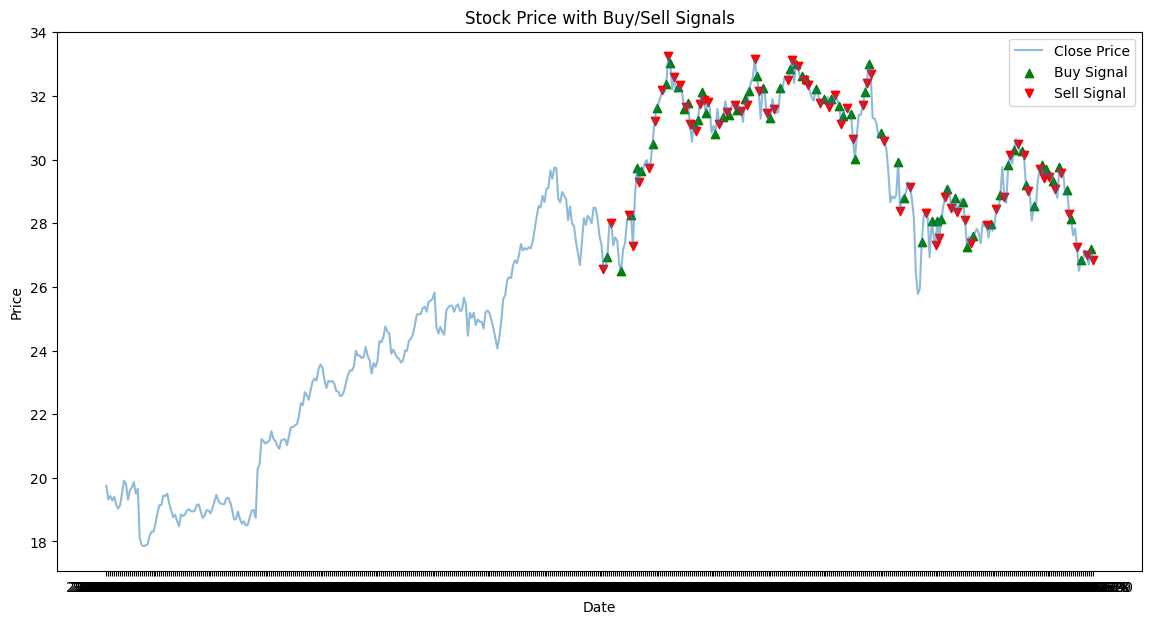

In [ ]:
plt.figure(figsize=(14, 7))
plt.plot(stock_data['Close'], label='Close Price', alpha=0.5)
plt.scatter(signals.loc[signals['Signal'] == 'Buy'].index, stock_data.loc[signals.loc[signals['Signal'] == 'Buy'].index]['Close'], label='Buy Signal', marker='^', color='g', alpha=1)
plt.scatter(signals.loc[signals['Signal'] == 'Sell'].index, stock_data.loc[signals.loc[signals['Signal'] == 'Sell'].index]['Close'], label='Sell Signal', marker='v', color='r', alpha=1)
plt.title('Stock Price with Buy/Sell Signals')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()


Step 6: Calculate Portfolio Returns and Performance Metrics

In [ ]:
# Initialize variables for portfolio calculation
initial_balance = 100000
balance = initial_balance
positions = 0
portfolio_value = []

# Calculate portfolio value over time
for i in range(len(stock_data)):
    if stock_data['Predictions'].iloc[i] == 1 and positions == 0:
        positions = balance / stock_data['Close'].iloc[i]
        balance = 0
    elif stock_data['Predictions'].iloc[i] == 0 and positions > 0:
        balance = positions * stock_data['Close'].iloc[i]
        positions = 0
    portfolio_value.append(balance + positions * stock_data['Close'].iloc[i])

# Convert portfolio value to a DataFrame
portfolio_value = pd.DataFrame(portfolio_value, index=stock_data.index, columns=['Portfolio Value'])

# Calculate returns and performance metrics
returns = portfolio_value.pct_change()
sharpe_ratio = (returns.mean() / returns.std()) * np.sqrt(150)

# Calculate maximum drawdown
rolling_max = portfolio_value.cummax()
drawdown = portfolio_value / rolling_max - 1
max_drawdown = drawdown.min()

# Calculate number of trades and win ratio
trades = len(signals)
win_trades = len(signals[(signals['Signal'] == 'Sell') & (stock_data['Close'].diff() > 0)])
win_ratio = win_trades / (trades / 4)

print("Sharpe Ratio:", sharpe_ratio)
print("Maximum Drawdown:", max_drawdown)
print("Number of Trades Executed:", trades)
print("Win Ratio:", win_ratio)


Sharpe Ratio: Portfolio Value   -0.019209
dtype: float64
Maximum Drawdown: Portfolio Value   -0.134485
dtype: float64
Number of Trades Executed: 133
Win Ratio: 0.631578947368421


<ipython-input-11-0a434c1dd330>:31: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  win_trades = len(signals[(signals['Signal'] == 'Sell') & (stock_data['Close'].diff() > 0)])
